In [1]:
# Has multi-dimensional arrays and matrices.
# Has a large collection of mathematical functions to operate on these arrays.
import numpy as np

# Data manipulation and analysis.
import pandas as pd

# Data visualization tools.
import seaborn as sns

import mesa

# Import Cell Agent and OrthogonalMooreGrid
from mesa.discrete_space import CellAgent, OrthogonalMooreGrid

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.agents]
    x = sorted(agent_wealths)
    n = model.num_agents
    B = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
    return 1 + (1 / n) - 2 * B


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth."""

    def __init__(self, model, cell):
        super().__init__(model)
        self.cell = cell
        self.wealth = 1
        self.steps_not_given = 0

    def move(self):
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        cellmates = [a for a in self.cell.agents if a is not self]

        if len(cellmates) > 0 and self.wealth > 0:
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1
            self.steps_not_given = 0
        else:
            self.steps_not_given += 1


class MoneyModel(mesa.Model):
    """A model with some number of agents."""

    def __init__(self, n, width, height, seed=None):
        super().__init__(seed=seed)
        self.num_agents = n
        self.grid = OrthogonalMooreGrid(
            (width, height), torus=True, capacity=10, random=self.random
        )
        # Instantiate DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": "wealth", "Steps_not_given": "steps_not_given"},
        )
        self.running = True

        # Create agents
        agents = MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

    def step(self):
        # Collect data each step
        self.datacollector.collect(self)
        self.agents.shuffle_do("move")
        self.agents.do("give_money")

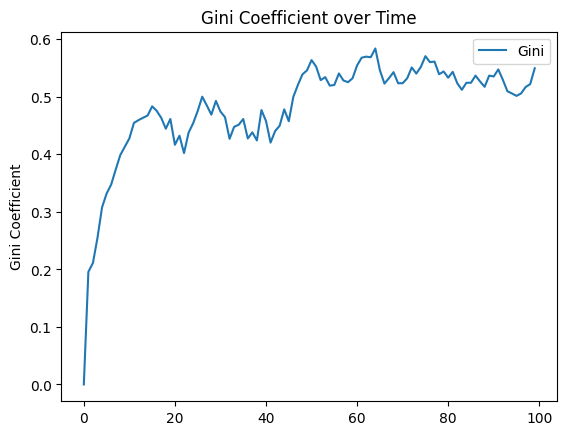

In [3]:
model = MoneyModel(100, 10, 10)
for _ in range(100):
    model.step()

gini = model.datacollector.get_model_vars_dataframe()
g = sns.lineplot(data=gini)
g.set(title="Gini Coefficient over Time", ylabel="Gini Coefficient");

In [5]:
import sys

from mesa.batchrunner import batch_run

params = {"width": 10, "height": 10, "n": range(5, 105, 5)}

results = batch_run(
    MoneyModel,
    parameters=params,
    iterations=5,                 # <-- this is the “5 iterations”
    max_steps=100,
    number_processes=1,
    data_collection_period=1,
    display_progress=True,
)


  0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
results_df = pd.DataFrame(results)
print(f"The results have {len(results)} rows.")
print(f"The columns of the data frame are {list(results_df.keys())}.")

The results have 525100 rows.
The columns of the data frame are ['RunId', 'iteration', 'Step', 'width', 'height', 'n', 'Gini', 'AgentID', 'Wealth', 'Steps_not_given'].


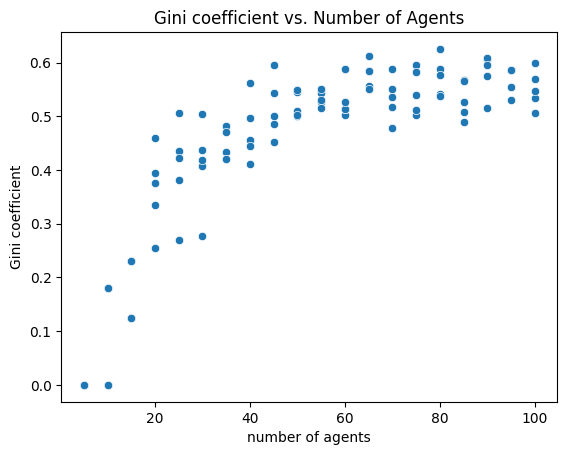

In [7]:
# Filter the results to only contain the data of one agent
# The Gini coefficient will be the same for the entire population at any time
results_filtered = results_df[(results_df.AgentID == 1) & (results_df.Step == 100)]
results_filtered[["iteration", "n", "Gini"]].reset_index(
    drop=True
).head()  # Create a scatter plot
g = sns.scatterplot(data=results_filtered, x="n", y="Gini")
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. Number of Agents",
);

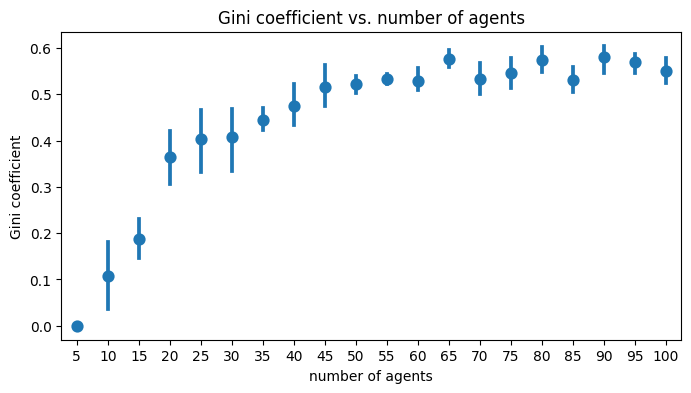

In [8]:
# Create a point plot with error bars
g = sns.pointplot(data=results_filtered, x="n", y="Gini", linestyle="None")
g.figure.set_size_inches(8, 4)
g.set(
    xlabel="number of agents",
    ylabel="Gini coefficient",
    title="Gini coefficient vs. number of agents",
);

In [9]:
# First, we filter the results
one_episode_wealth = results_df[(results_df.n == 10) & (results_df.iteration == 2)]
# Then, print the columns of interest of the filtered data frame
print(
    one_episode_wealth.to_string(
        index=False, columns=["Step", "AgentID", "Wealth"], max_rows=10
    )
)
# For a prettier display we can also convert the data frame to html
# Uncomment the two lines below to test in Jupyter
# from IPython.display import display, HTML
# display(HTML(one_episode_wealth.to_html(index=False, columns=['Step',
# 'AgentID', 'Wealth'], max_rows=25)))

 Step  AgentID  Wealth
    0      NaN     NaN
    1      1.0     1.0
    1      2.0     1.0
    1      3.0     1.0
    1      4.0     1.0
  ...      ...     ...
  100      6.0     1.0
  100      7.0     1.0
  100      8.0     1.0
  100      9.0     1.0
  100     10.0     1.0


In [10]:
results_one_episode = results_df[
    (results_df.n == 10) & (results_df.iteration == 1) & (results_df.AgentID == 1)
]
print(results_one_episode.to_string(index=False, columns=["Step", "Gini"], max_rows=10))

 Step  Gini
    1  0.00
    2  0.00
    3  0.00
    4  0.00
    5  0.00
  ...   ...
   96  0.18
   97  0.18
   98  0.18
   99  0.18
  100  0.18
